In [46]:
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math

MEASURE_SEPARATOR = "|--|"
LINE_SEPARATOR = "\n------------------\n"
FAILED_MEASUREMENT = "*"
class dataParser:
    def __init__(self, dataPath):
        self.dataPath = dataPath
        
    def getMetrics(self):
        # all the metrics we care about keeping track of
        popularity = []
        websites = []
        countries = []
        latencies = []
        routeLengths = []
        routeLatencies = []
        bytesGrabbed = []
        
        for chunk in self.getFileChunks():
            # each chunks components
            measures = self.chunkComponents(chunk)
            
            # minimal processing required here, grab information as is
            popularity.append(int(measures[0]))
            websites.append(measures[1])
            countries.append(measures[2])
            bytesGrabbed.append(int(measures[5][:-1]))
            
            # some processing needed - more complex string manipulations needed
            latency = self.extractLatency(measures[3])
            latencies.append(latency)
            
            routeLength = self.extractRouteLength(measures[4])
            routeLengths.append(routeLength)
            
            routeLatency = self.extractRouteTimes(measures[4])
            routeLatencies.append(routeLatency)

        return (popularity, websites, countries, latencies, routeLengths, routeLatencies, bytesGrabbed)
    
    def extractLatency(self, latencyString):
        timeIdx = latencyString.index("time ")
        timeEndIdx = latencyString.index("ms")
        if timeIdx > -1:
            return float(latencyString[timeIdx + len("time "):timeEndIdx])    
        return -1
    
    def extractRouteLength(self, routeLengthString):
        return routeLengthString.count("\n") - 1
    
    def extractRouteTimes(self, routesString):
        routeTimes = []
        firstNewlineIdx = routesString.index("\n") + len("\n")
        routeLines = routesString[firstNewlineIdx:-1].split("\n")
        for route in routeLines:
            if route[-1] != FAILED_MEASUREMENT:
                timingMarker = route.rfind(" ms")
                routeWithoutTimingMarker = route[:timingMarker]
                timeMarker = routeWithoutTimingMarker.rfind(" ") + len(" ")
                routeTimes.append(float(route[timeMarker:timingMarker]))
            else:
                routeTimes.append(routeTimes[-1]) # we assume for routes that are not reported, the route time was identical to the last recorded route time
        return routeTimes
    
    def chunkComponents(self, chunk):
        return chunk.split(MEASURE_SEPARATOR)
    
    def getFileChunks(self):
        file = self.fileAsText()
        splitFile = file.split(LINE_SEPARATOR)
        return splitFile[:-1] # remove the last lineSeparator of the file
    
    def fileAsText(self):
        with open(self.dataPath, 'r') as file:
            fileContents = file.read()
            return fileContents

class analyzeData:
    def __init__(self, metrics):
        (self.popularity,
        self.websites,
        self.countries,
        self.latencies,
        self.routeLengths,
        self.routeLatencies,
        self.bytesGrabbed) = metrics
    
    def analyzeNetworkLatencyToCountries(self):
        latenciesOverCountries = {}
        countriesCount = {}
        countriesSpecificData = {}
        for latency, country in zip(self.latencies, self.countries):
            if country in latenciesOverCountries.keys():
                latenciesOverCountries[country] += latency
                countriesCount[country] += 1
                countriesSpecificData[country].append(latency)
            else:
                latenciesOverCountries[country] = latency
                countriesCount[country] = 1
                countriesSpecificData[country] = [latency]
        
        deviationInLatencies = []
        for country, latency in latenciesOverCountries.items():
            total = latenciesOverCountries[country]
            latenciesOverCountries[country] = total/countriesCount[country]
            try:
                deviationInLatencies.append(statistics.stdev(countriesSpecificData[country]))
            except:
                deviationInLatencies.append(0)
            print(str(country) + " has standard deviation in latency : " + str(deviationInLatencies[-1]))
            
        plt.bar(latenciesOverCountries.keys(), latenciesOverCountries.values(), yerr=deviationInLatencies, capsize=10)
        plt.xlabel("Countries")
        plt.ylabel("Average Latencies")
        plt.title("Latency Vs Country")
        plt.show()
    
    def analyzeNetworkLatencyByRouteLength(self):
        # we are scattering x = route length
        # we are scattering y = latency
        plt.scatter(self.routeLengths, self.latencies)
        plt.xlabel("Route Lengths")
        plt.ylabel("Latencies")
        plt.title("Latency Vs Route Lengths through the network")
        
        #include a line of best fit
        slope, intercept = np.polyfit(self.routeLengths, self.latencies, deg=1)
        lineOfBestFit = slope * np.array(self.routeLengths) + intercept # numpy only wants to multiply with a numpy array, so we just make one here
        
        plt.plot(self.routeLengths, lineOfBestFit, label="line of best fit", color="green")
        plt.show()
        
        # additionally we should compute some correlation and stddev
        self.statsHelper(self.routeLengths, self.latencies, "Route Lengths", "Latencies")
    
    def analyzeLatenciesAlongRoutes(self):
        beginning, firstMiddle, secondMiddle, end = [], [], [], []
        for latencyList in self.routeLatencies:
            beginning.append(latencyList[0])
            end.append(latencyList[-1])
            
            if len(latencyList) < 4:
                firstMiddle.append(latencyList[0])
                if len(latencyList) < 3:
                    secondMiddle.append(latencyList[-1])
                else:
                    secondMiddle.append(latencyList[1])
                continue
            
            firstHalfIdx = int(math.floor(len(latencyList)/2))
            firstSection = latencyList[1:firstHalfIdx]
            secondSection = latencyList[firstHalfIdx + 1 : -1]
            firstMiddle.append(sum(firstSection)/len(firstSection))
            secondMiddle.append(sum(secondSection)/len(secondSection))
        
        print("Beginning : Median = " + str(statistics.median(beginning)) + " : Variance = " + str(statistics.stdev(beginning)))
        print("Beginning : Median = " + str(statistics.median(firstMiddle)) + " : Variance = " + str(statistics.stdev(firstMiddle)))
        print("Beginning : Median = " + str(statistics.median(secondMiddle)) + " : Variance = " + str(statistics.stdev(secondMiddle)))
        print("Beginning : Median = " + str(statistics.median(end)) + " : Variance = " + str(statistics.stdev(end)))
        plt.boxplot([beginning, firstMiddle, secondMiddle, end])
        plt.xlabel("Beginning | First Portion of Middle | Second Portion of Middle | End")
        plt.ylabel("Latencies along Network path")
        plt.show()
        
    def analyzeLatencyAlongPopularity(self):
        plt.scatter(self.popularity, self.latencies)
        plt.xlabel("Popularity (Descending Order)")
        plt.ylabel("Latency")
        plt.show()
        
        self.statsHelper(self.popularity, self.latencies, "Popularity Rating", "Latencies", modeX=False)
        
    def analyzeDownloadSizeAndLatency(self):
        latenciesForBytes = {}
        countforBytes = {}
        for bytes, latency in zip(self.bytesGrabbed, self.latencies):
            if bytes in latenciesForBytes.keys():
                latenciesForBytes[bytes] += latency
                countforBytes[bytes] += 1.0
            else:
                latenciesForBytes[bytes] = latency
                countforBytes[bytes] = 1.0
        
        for bytes, latency in latenciesForBytes.items():
            latenciesForBytes[bytes] /= countforBytes[bytes]
        
        plt.scatter(latenciesForBytes.keys(), latenciesForBytes.values())
        plt.xlabel("Bytes Downloaded")
        plt.ylabel("Latency")
        plt.show()
        
        self.statsHelper(self.bytesGrabbed, self.latencies, "Downloaded Bytes", "Latencies")
        
    def statsHelper(self, xarray, yarray, xname, yname, correlation=True, stdev=True, modeX=True, modeY=True, covariance=True, median=True):
        stddev = statistics.stdev(xarray)
        correlation = statistics.correlation(xarray, yarray)
        covariance = statistics.covariance(xarray, yarray)
        modeX = statistics.mode(xarray)
        modeY = statistics.mode(yarray)
        median = statistics.median(yarray)
        if correlation: print("Correlation Between " + xname + " and " + str(yname) + " : " + str(correlation))
        if stdev: print("Standard Deviation for "  + xname + " vs " + str(yname) + " : " + str(stddev))
        if modeX: print("Most Typical " + xname + " : " + str(modeX))
        if modeY: print("Most Typical " + yname + " : " + str(modeY))
        if covariance: print("Covariance of Variables : " + str(covariance))
        if median: print("Median " + yname + " : " + str(median))

In [47]:
parser = dataParser('data.txt')
m = parser.getMetrics()
analyzer = analyzeData(m)

United States has standard deviation in latency : 2.1213203435596424
Australia has standard deviation in latency : 0


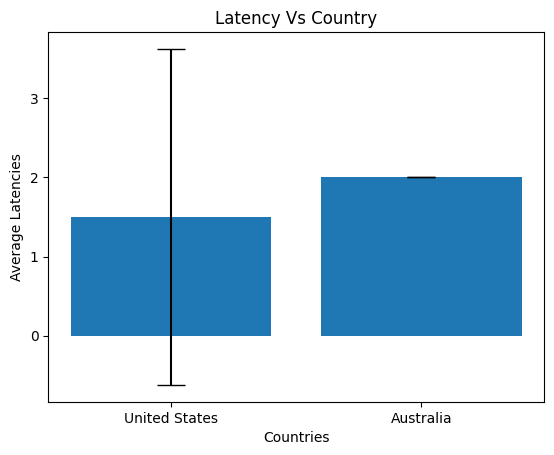

In [48]:
analyzer.analyzeNetworkLatencyToCountries()

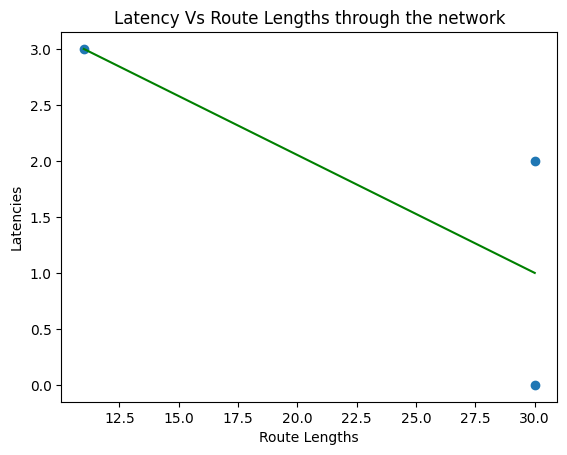

Correlation Between Route Lengths and Latencies : -0.7559289460184544
Standard Deviation for Route Lengths vs Latencies : 10.96965511460289
Most Typical Route Lengths : 30
Most Typical Latencies : 3.0
Covariance of Variables : -12.666666666666666
Median Latencies : 2.0


In [49]:
analyzer.analyzeNetworkLatencyByRouteLength()

Beginning : Median = 0.852 : Variance = 0.3355756248597327
Beginning : Median = 106.155 : Variance = 37.20252230684765
Beginning : Median = 130.7805 : Variance = 25.598022014189972
Beginning : Median = 117.504 : Variance = 52.33481671889182


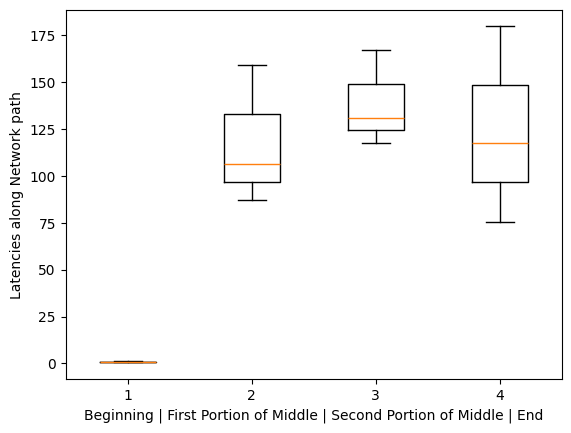

In [50]:
analyzer.analyzeLatenciesAlongRoutes()

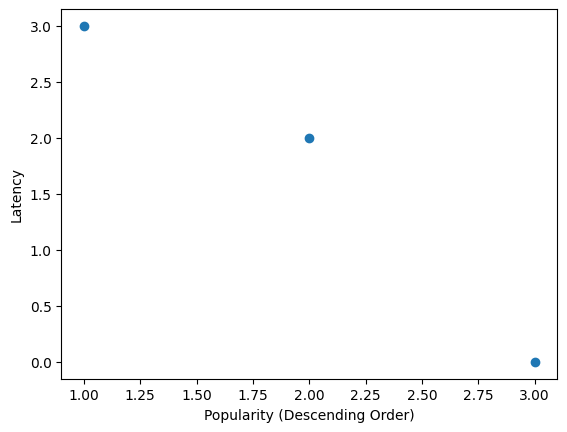

Correlation Between Popularity Rating and Latencies : -0.9819805060619656
Standard Deviation for Popularity Rating vs Latencies : 1.0
Most Typical Popularity Rating : 1
Most Typical Latencies : 3.0
Covariance of Variables : -1.5
Median Latencies : 2.0


In [52]:
analyzer.analyzeLatencyAlongPopularity()

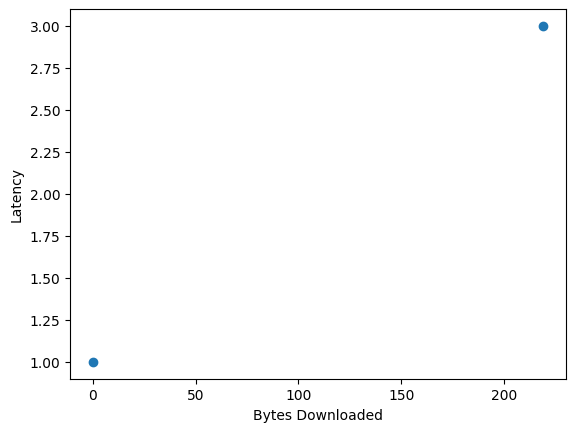

Correlation Between Downloaded Bytes and Latencies : 0.7559289460184544
Standard Deviation for Downloaded Bytes vs Latencies : 126.43970895252804
Most Typical Latencies : 3.0
Covariance of Variables : 146.0
Median Latencies : 2.0


In [53]:
analyzer.analyzeDownloadSizeAndLatency()